Number of good matches: 13
8


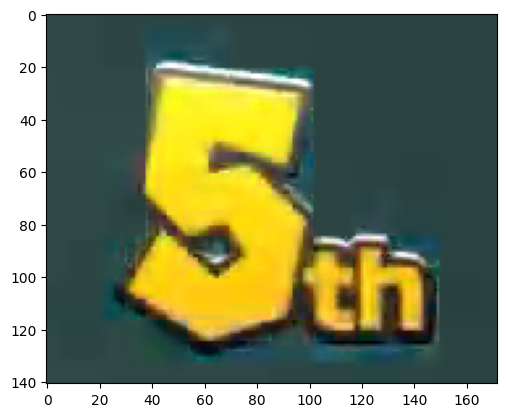

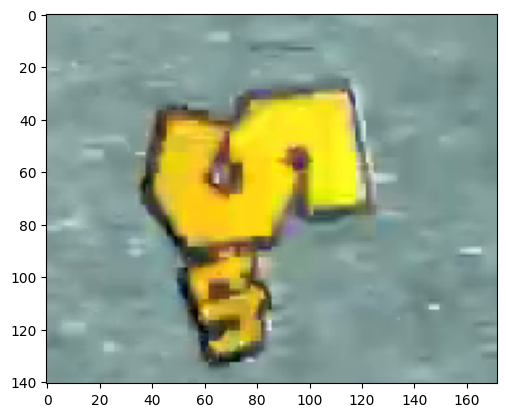

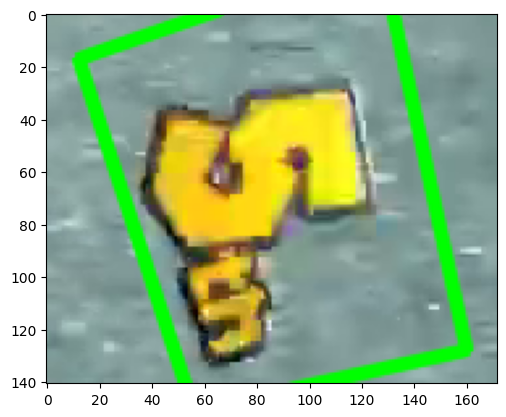

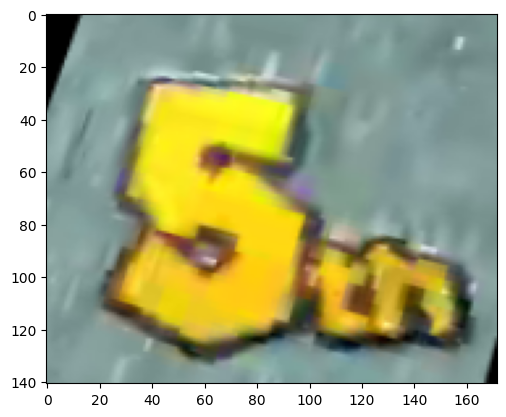

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mk8cv.models.position_classifier import CannyMaskPositionClassifier
from mk8cv.data.state import Player

def find_and_correct_match(template, target):
    # Convert images to grayscale
    plt.figure()
    plt.imshow(template)
    plt.figure()
    plt.imshow(target)

    template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    target_gray = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Find keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(template_gray, None)
    kp2, des2 = sift.detectAndCompute(target_gray, None)

    # Match descriptors
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    print(f"Number of good matches: {len(good_matches)}")

    if len(good_matches) < 4:
        print("Not enough good matches to calculate homography.")
        return target, None  # Return original image if not enough matches

    # Get matched keypoints
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Find homography
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    if M is None:
        print("Could not calculate homography.")
        return target, None  # Return original image if homography calculation fails


    # Get dimensions of template
    h, w = template.shape[:2]

    # Apply homography to corners of template
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)

    # Draw bounding box around matched region
    result = cv2.polylines(target.copy(), [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA)
    
    # Get dimensions of template and target
    h_temp, w_temp = template.shape[:2]
    h_target, w_target = target.shape[:2]

    # Calculate the inverse homography
    M_inv = np.linalg.inv(M)

    # Apply inverse homography to the entire target image
    corrected_image = cv2.warpPerspective(target, M_inv, (w_target, h_target))

    # Calculate the bounding box of the transformed template in the target image
    pts = np.float32([[0, 0], [0, h_temp-1], [w_temp-1, h_temp-1], [w_temp-1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)
    
    # Calculate the min and max coordinates to crop the corrected image
    min_x, min_y = np.int32(dst.min(axis=0).ravel())
    max_x, max_y = np.int32(dst.max(axis=0).ravel())
    
    # Ensure the crop coordinates are within the image boundaries
    min_x, min_y = max(min_x, 0), max(min_y, 0)
    max_x, max_y = min(max_x, w_target), min(max_y, h_target)

    # Crop the corrected image
    cropped_corrected = corrected_image[min_y:max_y, min_x:max_x]

    # Resize the cropped image to match the template size
    final_corrected = cv2.resize(cropped_corrected, (w_temp, h_temp))

    return final_corrected, result

# Load images
template = cv2.imread('../templates/position/05.png')
target = cv2.imread('../race_videos/training/position/Player.P2/001136.png')

# Find match
corrected_image, homography = find_and_correct_match(template, target)


# Display result
plt.figure()
plt.imshow(homography)
plt.figure()
plt.imshow(corrected_image)

model = CannyMaskPositionClassifier()
model.load()

pos = model.extract_player_position(corrected_image, Player.P1)
print(pos)
